<a href="https://colab.research.google.com/github/lerdeljan17/IMDB-linear-regression/blob/main/IMDB_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB web crawler

Here we wil scrape the imdb website for sci-fi movies. While scraping we will use a delay so that we don't get blocked and we will do some transformations on the data along the way and place it in lists and then combine them in a pandas data frame. The we will do some data cleaning.

In [ ]:
from requests import get
from bs4 import BeautifulSoup
from warnings import warn
from time import sleep
from random import randint
import numpy as np, pandas as pd
import seaborn as sns

## Web scraping and crawling

In [ ]:
# Note this takes about 40 min to run if np.arange is set to 9951 as the stopping point.

pages = np.arange(1, 9951, 50) # go to 10000 items (4 pages) because after that the URI has no discernable pattern to combat webcrawlers;
headers = {'Accept-Language': 'en-US,en;q=0.8'} # If this is not specified, the default language is Mandarin

#initialize empty lists to store the variables scraped
titles = []
years = []
ratings = []
genres = []
runtimes = []
imdb_ratings = []
imdb_ratings_standardized = []
metascores = []
votes = []

for page in pages:
  
  #get request for sci-fi
  response = get("https://www.imdb.com/search/title?genres=sci-fi&"
                + "start="
                + str(page)
                + "&explore=title_type,genres&ref_=adv_prv", headers=headers)

  sleep(randint(8,15))

  #throw warning for status codes that are not 200
  if response.status_code != 200:
      warn('Request: {}; Status code: {}'.format(requests, response.status_code))

  #parse the content of current iteration of request
  page_html = BeautifulSoup(response.text, 'html.parser')
    
  movie_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')

  #extract the 50 movies for that page
  for container in movie_containers:

      #conditional for all with metascore
      if container.find('div', class_ = 'ratings-metascore') is not None:

          #title
          title = container.h3.a.text
          titles.append(title)

          if container.h3.find('span', class_= 'lister-item-year text-muted unbold') is not None:
          
            #year released
            year = container.h3.find('span', class_= 'lister-item-year text-muted unbold').text # remove the parentheses around the year and make it an integer
            years.append(year)

          else:
            years.append(None) # each of the additional if clauses are to handle type None data, replacing it with an empty string so the arrays are of the same length at the end of the scraping

          if container.p.find('span', class_ = 'certificate') is not None:
          
            #rating
            rating = container.p.find('span', class_= 'certificate').text
            ratings.append(rating)

          else:
            ratings.append("")

          if container.p.find('span', class_ = 'genre') is not None:
          
            #genre
            genre = container.p.find('span', class_ = 'genre').text.replace("\n", "").rstrip().split(',') # remove the whitespace character, strip, and split to create an array of genres
            genres.append(genre)
        
          else:
            genres.append("")

          if container.p.find('span', class_ = 'runtime') is not None:

            #runtime
            time = int(container.p.find('span', class_ = 'runtime').text.replace(" min", "")) # remove the minute word from the runtime and make it an integer
            runtimes.append(time)

          else:
            runtimes.append(None)

          if float(container.strong.text) is not None:

            #IMDB ratings
            imdb = float(container.strong.text)
            imdb_ratings.append(imdb)

          else:
            imdb_ratings.append(None)

          if container.find('span', class_ = 'metascore').text is not None:

            #Metascore
            m_score = int(container.find('span', class_ = 'metascore').text) # make it an integer
            metascores.append(m_score)

          else:
            metascores.append(None)

          if container.find('span', attrs = {'name':'nv'})['data-value'] is not None:

            #Number of votes
            vote = int(container.find('span', attrs = {'name':'nv'})['data-value'])
            votes.append(vote)

          else:
            votes.append(None)

## Data cleaning

In [ ]:
sci_fi_df = pd.DataFrame({'movie': titles,
                      'year': years,
                      'rating': ratings,
                      'genre': genres,
                      'runtime_min': runtimes,
                      'imdb': imdb_ratings,
                      'metascore': metascores,
                      'votes': votes}
                      )

sci_fi_df.loc[:, 'year'] = sci_fi_df['year'].str[-5:-1] # remove parentheses 
# # Drop 'ovie' bug
# # Make year an int
sci_fi_df['n_imdb'] = sci_fi_df['imdb'] * 10 # normalize the imdb rating
final_df = sci_fi_df.loc[sci_fi_df['year'] != 'ovie'] # issue with the scrape on two movies so just dropping those ones.
final_df.loc[:, 'year'] = pd.to_numeric(final_df['year'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
# write df to csv
final_df.to_csv('/content/drive/MyDrive/Data mining/imdb.csv',index=False)

# Read data form CSV

Here we will do some explorative analysis, to see what our data looks like.

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/Data mining/imdb.csv');

# Explorative analysis 

In [ ]:
final_df.head()

,movie,year,rating,genre,runtime_min,imdb,metascore,votes,n_imdb
0,Don't Worry Darling,2022,R,"['Drama', ' Sci-Fi', ' Thriller']",123,6.3,48,29086,63.0
1,The Munsters,2022,PG,"['Comedy', ' Family', ' Fantasy']",109,4.6,57,6296,46.0
2,Thor: Love and Thunder,2022,PG-13,"['Action', ' Adventure', ' Comedy']",118,6.4,57,280659,64.0
3,Avatar,2009,PG-13,"['Action', ' Adventure', ' Fantasy']",162,7.8,83,1234071,78.0
4,Nope,2022,R,"['Horror', ' Mystery', ' Sci-Fi']",130,6.9,77,135448,69.0


In [ ]:
final_df.describe()

,year,runtime_min,imdb,metascore,votes,n_imdb
count,1333.000000,1333.000000,1333.000000,1333.000000,1.333000e+03,1333.000000
mean,2004.561140,105.090773,6.112603,52.975244,1.351655e+05,61.126032
std,15.670506,18.518435,1.068814,17.004066,2.300650e+05,10.688141
min,1927.000000,60.000000,1.500000,6.000000,7.800000e+01,15.000000
25%,1997.000000,92.000000,5.500000,41.000000,1.011100e+04,55.000000
50%,2009.000000,101.000000,6.200000,53.000000,4.087700e+04,62.000000
75%,2017.000000,114.000000,6.800000,65.000000,1.478010e+05,68.000000
max,2022.000000,242.000000,8.800000,98.000000,2.322738e+06,88.000000


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1333 entries, 0 to 1332
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        1333 non-null   object 
 1   year         1333 non-null   int64  
 2   rating       1284 non-null   object 
 3   genre        1333 non-null   object 
 4   runtime_min  1333 non-null   int64  
 5   imdb         1333 non-null   float64
 6   metascore    1333 non-null   int64  
 7   votes        1333 non-null   int64  
 8   n_imdb       1333 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 93.9+ KB


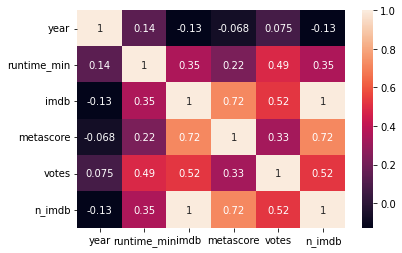

In [ ]:
sns.heatmap(final_df.corr(), annot=True);

We can see that the strongest correlation is between the IMDB score and the metascore.
The next strongest correlation you can see is between the IMDB rating and the number of votes.

The number of votes roughly increases as the runtime increases as well.

In [ ]:
from matplotlib import pyplot as plt

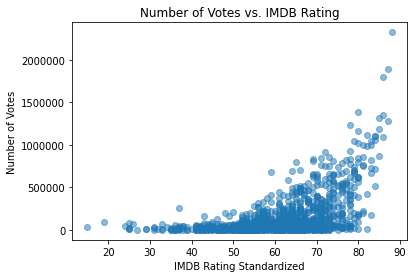

In [ ]:
x = final_df['n_imdb']
y = final_df['votes']
plt.scatter(x, y, alpha=0.5) # s= is size var, c= is color var
plt.xlabel("IMDB Rating Standardized")
plt.ylabel("Number of Votes")
plt.title("Number of Votes vs. IMDB Rating")
plt.ticklabel_format(style='plain')
plt.show()

We can see that there are some outliers but generally the there seem to be a greater number of votes on movies with ratings above 85 and fewer votes on movies with 75 or less

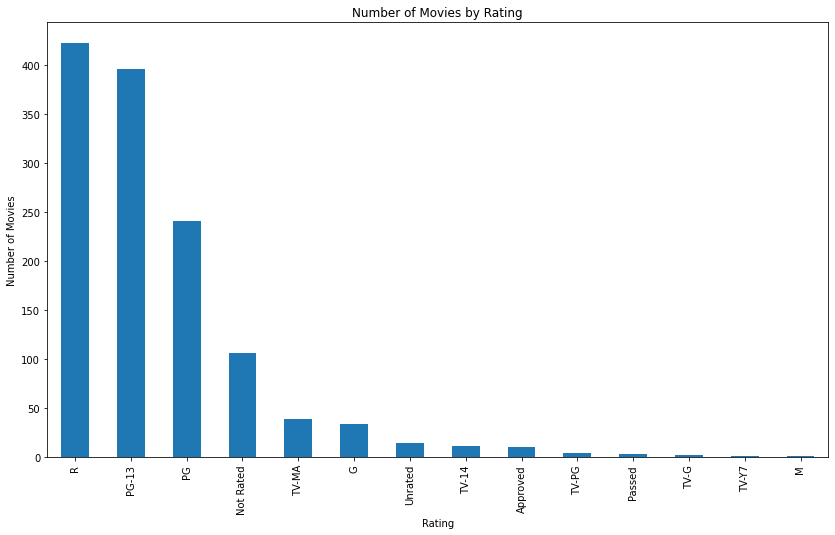

In [ ]:
ax = final_df['rating'].value_counts().plot(kind='bar',
                                   figsize=(14,8),
                                   title="Number of Movies by Rating")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Movies")
ax.plot();

R and PG-13 make up the majority of these Sci-Fi movies on IMDB.

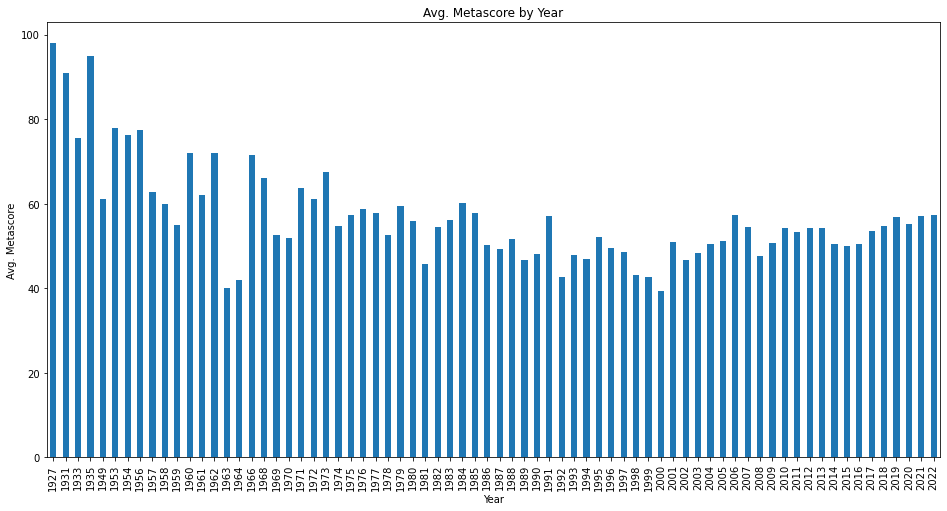

In [ ]:
# average metascores by year
final_df.groupby('year')['metascore'].mean().plot(kind='bar', figsize=(16,8), title="Avg. Metascore by Year", xlabel="Year", ylabel="Avg. Metascore")
plt.xticks(rotation=90)
plt.plot();

The average metascore decreases through history. The ratings level out around 55-60 in the last couple decades. This might be due to newer movies having more reviews.

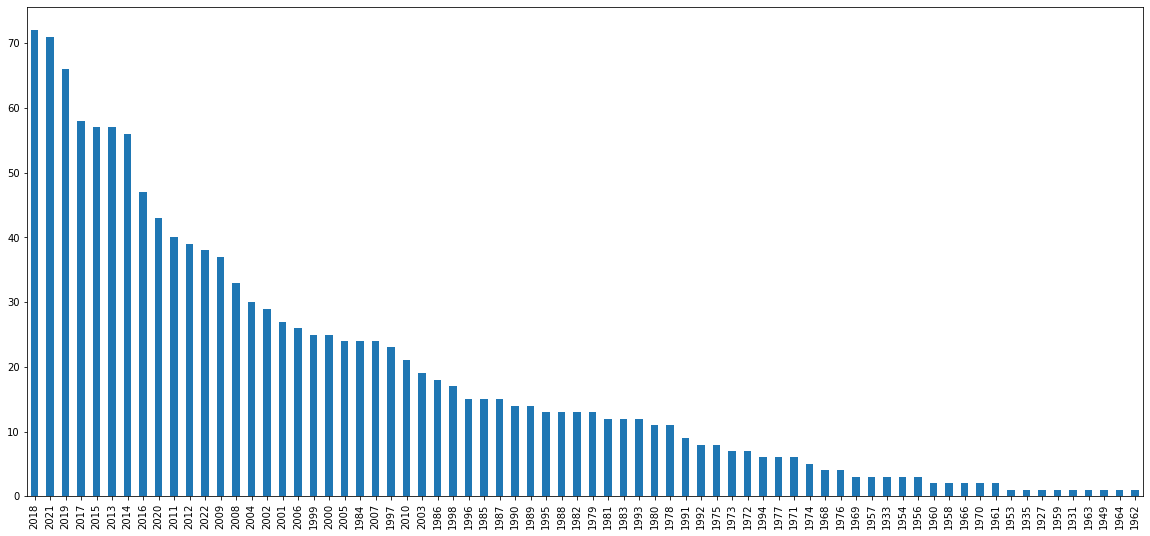

In [ ]:
# number of movies by year
final_df['year'].value_counts().plot(kind='bar', figsize=[20,9])

Here we can see thtat older years have a lot less movies, e.g. 1927 has oly one movie which makes it very biased and over-inflated

#Linear Regression

Based on the analysis we did in the previous section i think that the cnadidates for predicting the imdb score are metascore, number of votes and maybe runtime.

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline
sns.set(style = 'darkgrid')
sns.set_palette('deep')

##Metascore

In [ ]:
# divide the data into attributes and labels
X = final_df.drop(['n_imdb', 'movie', 'rating', 'genre','year', 'runtime_min', 'imdb', 'votes'], axis = 1)
y = final_df['n_imdb']

In [ ]:
X

,metascore
0,48
1,57
2,57
3,83
4,77
...,...
1328,68
1329,71
1330,47
1331,40


In [ ]:
# split 80% of the data to the training set and 20% of the data to test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
predictions = lr.predict(X_test)

###Predictions

In [ ]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()}).head(25)
pred.head(10)

,Actual,Predicted
0,69.0,59.835341
1,70.0,67.527724
2,69.0,73.410134
3,47.0,53.952931
4,35.0,49.428000
5,57.0,55.762903
6,67.0,68.432710
7,55.0,56.667889
8,63.0,63.907779
9,53.0,46.713041


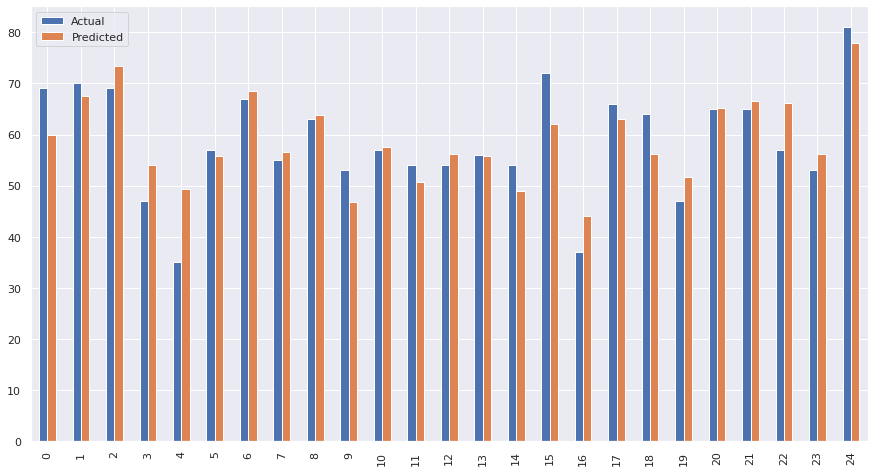

In [ ]:
# visualise the above comparison result
pred.plot(kind='bar', figsize=(15, 8))

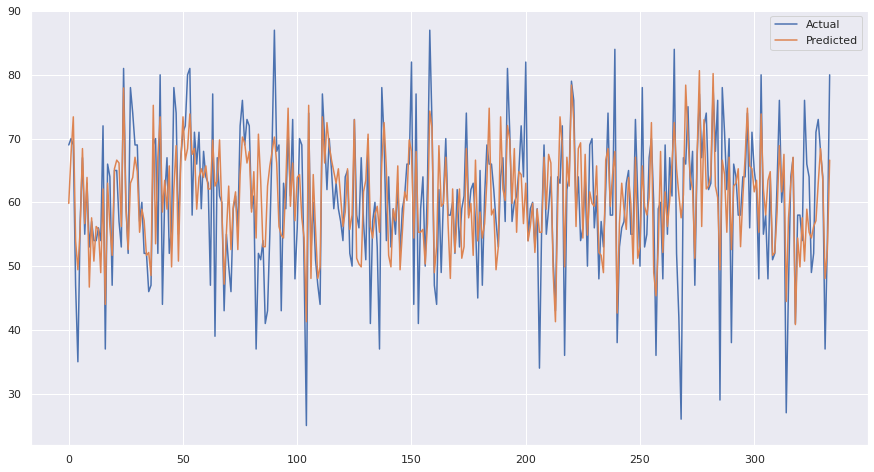

In [ ]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()})
pred.plot(kind='line', figsize=(15, 8))

In [ ]:
# evaluate the performance of the algorithm
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 6.080819272545623
MSE: 63.07421827303484
RMSE: 7.94192786878821


## Metscore and votes

In [ ]:
# divide the data into attributes and labels
X = final_df.drop(['n_imdb', 'movie', 'rating', 'genre','year', 'runtime_min', 'imdb'], axis = 1)
y = final_df['n_imdb']

In [ ]:
X

,metascore,votes
0,48,29086
1,57,6296
2,57,280659
3,83,1234071
4,77,135448
...,...,...
1328,68,78
1329,71,200
1330,47,1313
1331,40,3361


In [ ]:
# split 80% of the data to the training set and 20% of the data to test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
predictions = lr.predict(X_test)

###Predictions

In [ ]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()}).head(25)
pred.head(10)

,Actual,Predicted
0,69.0,60.009991
1,70.0,65.680964
2,69.0,70.979898
3,47.0,53.342389
4,35.0,49.179558
5,57.0,55.076598
6,67.0,65.815581
7,55.0,55.445470
8,63.0,61.877062
9,53.0,48.342729


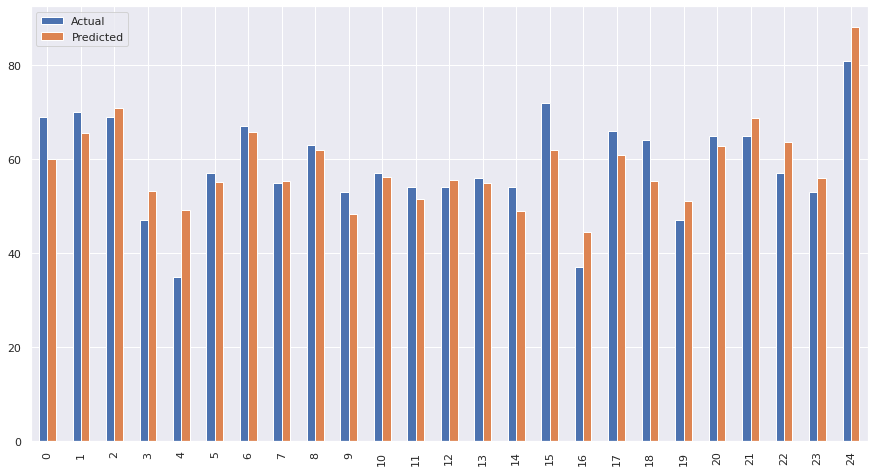

In [ ]:
# visualise the above comparison result
pred.plot(kind='bar', figsize=(15, 8))

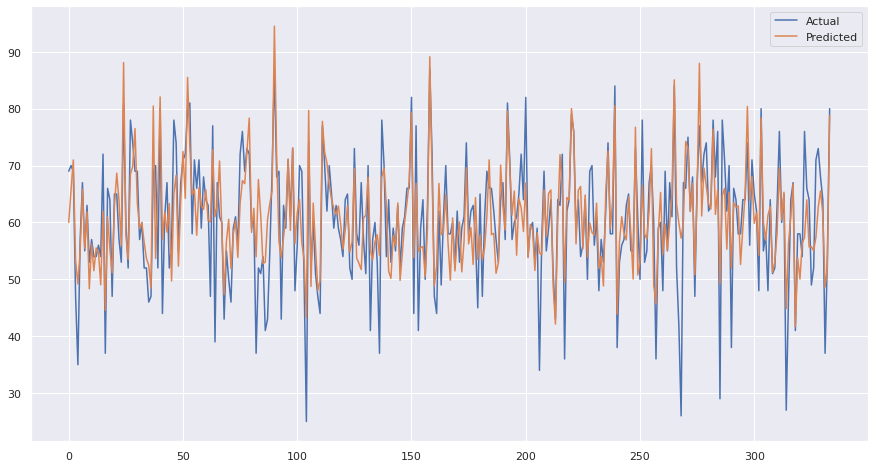

In [ ]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()})
pred.plot(kind='line', figsize=(15, 8))

In [ ]:
# evaluate the performance of the algorithm
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 5.352763372202901
MSE: 49.9668997980566
RMSE: 7.068726886650566


## Metscore, votes, runtime

In [ ]:
# divide the data into attributes and labels
X = final_df.drop(['n_imdb', 'movie', 'rating', 'genre','year', 'imdb'], axis = 1)
y = final_df['n_imdb']

In [ ]:
X

,runtime_min,metascore,votes
0,123,48,29086
1,109,57,6296
2,118,57,280659
3,162,83,1234071
4,130,77,135448
...,...,...,...
1328,108,68,78
1329,99,71,200
1330,102,47,1313
1331,136,40,3361


In [ ]:
# split 80% of the data to the training set and 20% of the data to test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
predictions = lr.predict(X_test)

###Predictions 

In [ ]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()}).head(25)
pred.head(10)

,Actual,Predicted
0,69.0,59.387775
1,70.0,65.060452
2,69.0,71.238769
3,47.0,52.682545
4,35.0,48.580383
5,57.0,54.385313
6,67.0,65.049646
7,55.0,54.831359
8,63.0,61.518889
9,53.0,48.636329


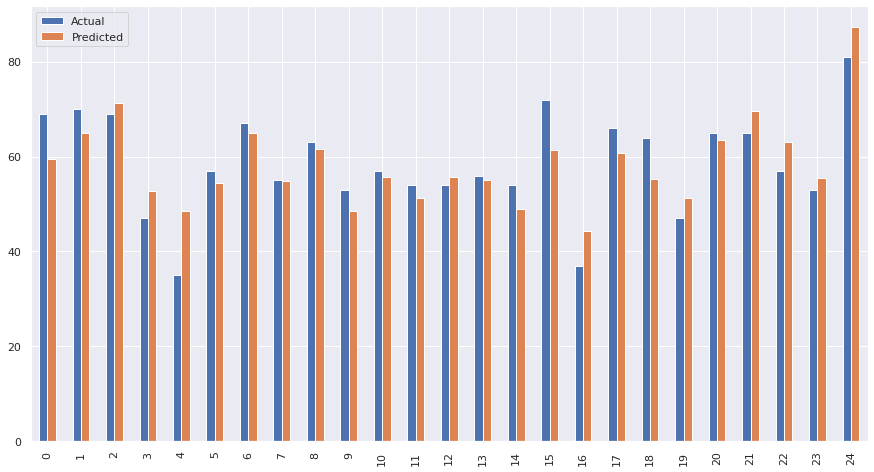

In [ ]:
# visualise the above comparison result
pred.plot(kind='bar', figsize=(15, 8))

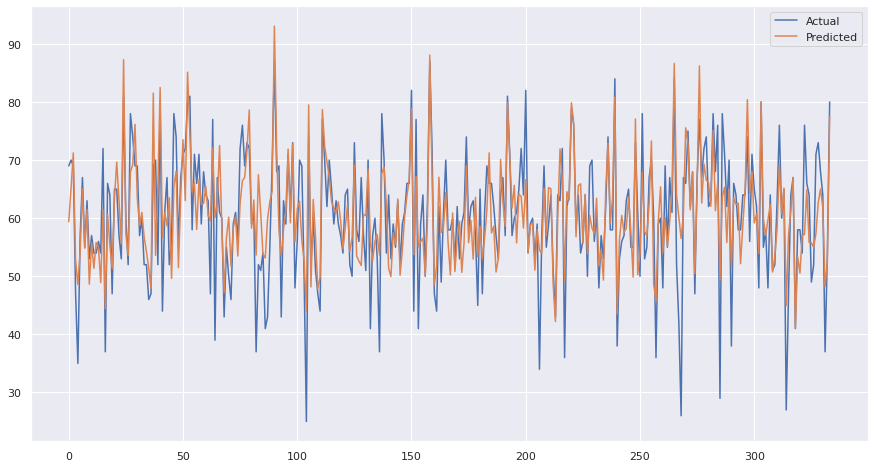

In [ ]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()})
pred.plot(kind='line', figsize=(15, 8))

In [ ]:
# evaluate the performance of the algorithm
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 5.329887908753191
MSE: 49.21795988313376
RMSE: 7.015551288611164


# Conclusion 

In each configuration we evaluated the model performance by looking at the mean absolute error(MAE), mean squared error and the square(MSE) root of the mean squred error(RMSe). At the end we can see that the predictions are relatively accurate and that adding votes slightly increases the accuracy but adding runtime does not add a lot to the overall accuracy of the model.


---


Metascore, votes, runtime:
MAE: 5.329887908753191
MSE: 49.21795988313376
RMSE: 7.015551288611164

---



Metascore, votes:
MAE: 5.352763372202901
MSE: 49.9668997980566
RMSE: 7.068726886650566

---



Metascore:
MAE: 6.080819272545623
MSE: 63.07421827303484
RMSE: 7.94192786878821